# ОИАД. Лабораторная работа №3

https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset?resource=download

## 1. Подготовка данных
1. проверить наличие пропусков и выбросов
2. привести категориальные признаки к числовым
3. вычислить парные корреляции признаков

In [1]:
import pandas as pd

df = pd.read_csv("insurance.csv")

In [2]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [4]:
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [5]:
import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outliers_info = {}
for c in num_cols:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    mask = (df[c] < low) | (df[c] > high)
    outliers_info[c] = int(mask.sum())

for k, v in outliers_info.items():
    print(f" {k}: {v}")

 age: 0
 bmi: 9
 children: 0
 charges: 139


In [ ]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

data = df.copy()
data["sex"] = (data["sex"] == "male").astype(int)
data["smoker"] = (data["smoker"] == "yes").astype(int)
data = pd.get_dummies(data, columns=["region"], drop_first=True)

data.head()

После кодирования:


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


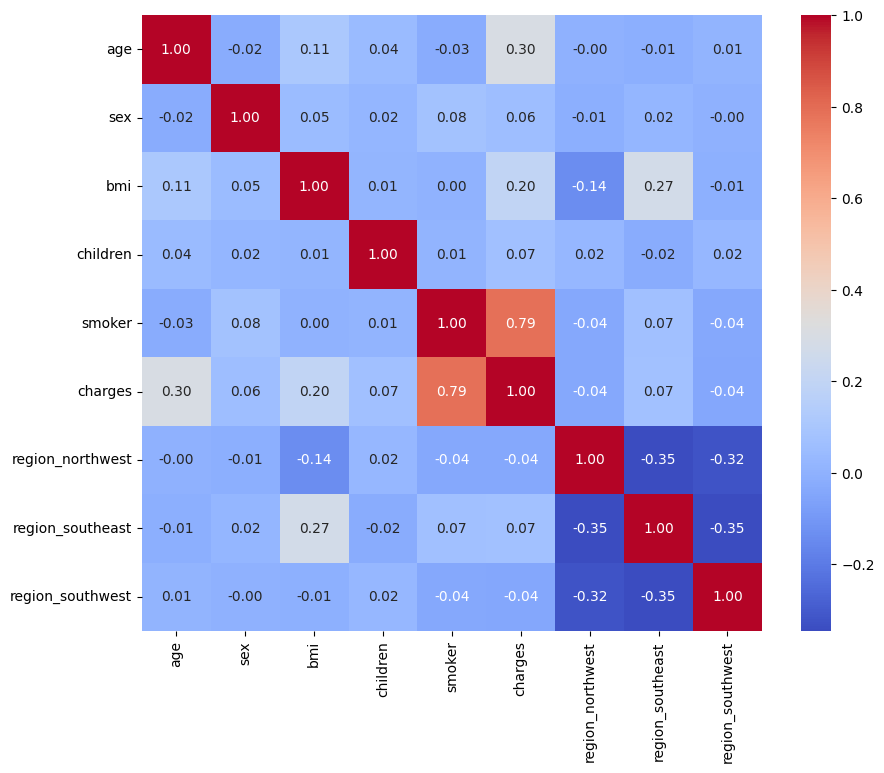

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры:
1. аналитически (реализовать самому)
2. численно, с помощью методов градиентного спуска (реализовать самому)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X = data.drop(columns=["charges"]).values
y = data["charges"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_b = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_b = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

In [9]:
def normal_equation(X, y, reg_lambda=0.0):
    n_features = X.shape[1]
    A = X.T @ X
    if reg_lambda != 0.0:
        L = reg_lambda * np.eye(n_features)
        L[0, 0] = 0.0
        A = A + L
    w = np.linalg.pinv(A) @ X.T @ y
    return w

In [ ]:
w_analytic = normal_equation(X_train_b, y_train)
y_pred_analytic = X_test_b @ w_analytic
print("Weights:", w_analytic)
print("MSE:", mean_squared_error(y_test, y_pred_analytic))

Weights: [[13169.28767103]
 [ 3657.4120322 ]
 [ -184.77384247]
 [ 1940.49791687]
 [  439.0427309 ]
 [ 9555.37706245]
 [ -211.08226648]
 [ -297.30707113]
 [ -387.85377954]]
MSE: 38254875.01877003


In [11]:
def gradient_descent(X, y, lr=0.01, n_iter=1000, reg_lambda=0.0):
    m, n = X.shape
    w = np.zeros((n, 1))
    for i in range(n_iter):
        pred = X @ w
        error = pred - y
        grad = (1 / m) * X.T @ error
        if reg_lambda != 0.0:
            reg_term = (reg_lambda / m) * w
            reg_term[0, 0] = 0.0
            grad = grad + reg_term
        w = w - lr * grad
    return w

In [ ]:
w_gd = gradient_descent(X_train_b, y_train, lr=0.1, n_iter=5000)
y_pred_gd = X_test_b @ w_gd
print("Weights:", w_gd)
print("MSE:", mean_squared_error(y_test, y_pred_gd))

Weights: [[13169.28767103]
 [ 3657.4120322 ]
 [ -184.77384247]
 [ 1940.49791687]
 [  439.0427309 ]
 [ 9555.37706245]
 [ -211.08226648]
 [ -297.30707113]
 [ -387.85377954]]
MSE: 38254875.01877011


## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически
2. численно

In [ ]:
reg_lambda = 35

w_analytic_ridge = normal_equation(X_train_b, y_train, reg_lambda=reg_lambda)
y_pred_analytic_ridge = X_test_b @ w_analytic_ridge
print("Weights:", w_analytic_ridge.ravel())
print("MSE:", mean_squared_error(y_test, y_pred_analytic_ridge))

w_gd_ridge = gradient_descent(X_train_b, y_train, lr=0.1, n_iter=5000, reg_lambda=reg_lambda)
y_pred_gd_ridge = X_test_b @ w_gd_ridge
print("Weights:",  w_gd_ridge.ravel())
print("MSE:", mean_squared_error(y_test, y_pred_gd_ridge))

Weights: [13169.28767103  3538.78429604  -156.28947265  1876.50106479
   432.88218813  9243.56905541  -195.92130426  -235.5190379
  -364.09892555]
MSE: 38737097.63023474
Weights: [13169.28767103  3538.78429604  -156.28947265  1876.50106479
   432.88218813  9243.56905541  -195.92130426  -235.5190379
  -364.09892555]
MSE: 38737097.630234815


## 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [14]:
mse = {}

y_mean = np.mean(y_train)
baseline_pred = np.full_like(y_test, y_mean)
mse["mse_baseline"] = mean_squared_error(y_test, baseline_pred)

mse["mse_analytic"] = mean_squared_error(y_test, y_pred_analytic)

mse["mse_gd"] = mean_squared_error(y_test, y_pred_gd)

mse["mse_analytic_ridge"] = mean_squared_error(y_test, y_pred_analytic_ridge)

mse["mse_gd_ridge"] = mean_squared_error(y_test, y_pred_gd_ridge)

for key, val in mse.items():
    print(f"{key}: {val:.4e}")

mse_baseline: 1.5732e+08
mse_analytic: 3.8255e+07
mse_gd: 3.8255e+07
mse_analytic_ridge: 3.8737e+07
mse_gd_ridge: 3.8737e+07
